In [1]:
!pip install tensorflow keras Pillow scipy

In [2]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [4]:
import os

def contar_arquivos(diretorio):
    return len([nome for nome in os.listdir(diretorio) if os.path.isfile(os.path.join(diretorio, nome))])

In [5]:
uri_dataset_positivo = 'dataset/Positive'
uri_dataset_negativo = 'dataset/Negative'

In [6]:
qntde_positivos = contar_arquivos(uri_dataset_positivo)
qntde_negativos = contar_arquivos(uri_dataset_negativo)

In [7]:
print('Quantidade de imagens com rachaduras: {}'.format(qntde_positivos))
print('Quantidade de imagens sem rachaduras: {}'.format(qntde_negativos))

Quantidade de imagens com rachaduras: 20000
Quantidade de imagens sem rachaduras: 20000


In [8]:
tx_train = round(.8, 3)
tx_test = round(1-tx_train, 3)

(tx_train, tx_test)

(0.8, 0.2)

## Pre-Processamento

In [41]:
from PIL import Image
import os

In [43]:
def convert_to_grayscale(img):
    """ Converte uma imagem para escala de cinza. """
    return img.convert('L')

def resize_image(img, size=(128, 128)):
    """ Redimensiona uma imagem para o tamanho especificado. """
    return img.resize(size)

In [108]:
# Caminho do diretório
dir_path = 'dataset_organized/train/positives/'

# Ler as primeiras 3 imagens
image_files = os.listdir(dir_path)[:3]
images = [Image.open(os.path.join(dir_path, file)) for file in image_files]



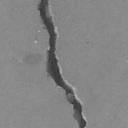

In [109]:
images[0]

In [110]:
np.asarray(images[0]).shape

(128, 128)

In [47]:
# Processamento das imagens
grayscale_images = [convert_to_grayscale(img) for img in images]

In [48]:
resized_images = [resize_image(img) for img in grayscale_images]

In [63]:
np.asarray(resized_images[0]).shape

(128, 128)

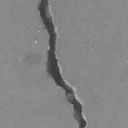

In [52]:
resized_images[0].

In [50]:
# Exibir as imagens processadas (opcional)
for img in resized_images:
    img.show()


## Vamos criar um novo repositório para a organização dos datasets.

> A ideia é separar os datasets em treino e teste.

In [67]:
import os
import random
import shutil
from tqdm import tqdm
from PIL import Image

def convert_to_grayscale(img):
    """ Converte uma imagem para escala de cinza. """
    return img.convert('L')

def resize_image(img, size=(128, 128)):
    """ Redimensiona uma imagem para o tamanho especificado. """
    return img.resize(size)

def dividir_e_copiar_arquivos(diretorio_origem, diretorio_treino, diretorio_teste, taxa_treino):
    # Cria os diretórios de treino e teste, se necessário
    if not os.path.exists(diretorio_treino):
        os.makedirs(diretorio_treino)
    if not os.path.exists(diretorio_teste):
        os.makedirs(diretorio_teste)

    # Lista todos os arquivos no diretório de origem
    arquivos = [arquivo for arquivo in os.listdir(diretorio_origem) if os.path.isfile(os.path.join(diretorio_origem, arquivo))]
    random.shuffle(arquivos)

    # Determina o ponto de corte para a divisão dos dados
    ponto_corte = int(len(arquivos) * taxa_treino)
    arquivos_treino = arquivos[:ponto_corte]
    arquivos_teste = arquivos[ponto_corte:]

    # Pré-processa e copia os arquivos para os diretórios de treino e teste com uma barra de progresso
    for arquivo in tqdm(arquivos_treino, desc="Copiando arquivos de treino"):
        img = Image.open(os.path.join(diretorio_origem, arquivo))
        img = convert_to_grayscale(img)
        img = resize_image(img)
        img.save(os.path.join(diretorio_treino, arquivo))

    for arquivo in tqdm(arquivos_teste, desc="Copiando arquivos de teste"):
        img = Image.open(os.path.join(diretorio_origem, arquivo))
        img = convert_to_grayscale(img)
        img = resize_image(img)
        img.save(os.path.join(diretorio_teste, arquivo))

# Exemplo de uso da função
# dividir_e_copiar_arquivos('caminho_para_o_diretorio_origem', 'caminho_para_o_diretorio_treino', 'caminho_para_o_diretorio_teste', 0.8)


In [68]:
# Caminho do diretório a ser verificado
dir_path = 'dataset_organized'

# Verificar se o diretório existe
if os.path.exists(dir_path):
    # Remover o diretório e seu conteúdo
    try:
        os.rmdir(dir_path)
        message = "Diretório 'dataset_organized' foi excluído com sucesso."
    except OSError as error:
        message = f"Erro ao excluir o diretório: {error}"
else:
    message = "O diretório 'dataset_organized' não existe."

In [69]:
dir_positives_train = f'{dir_path}/train/positives/'
dir_negatives_train = f'{dir_path}/train/negatives/'
dir_positives_test = f'{dir_path}/test/positives/'
dir_negatives_test = f'{dir_path}/test/negatives/'

In [70]:
%%time
dividir_e_copiar_arquivos(uri_dataset_positivo, dir_positives_train, dir_positives_test, tx_train)

Copiando arquivos de teste: 100%|█████████████████████████████████████████████████| 4000/4000 [00:10<00:00, 363.77it/s]

CPU times: total: 48.7 s
Wall time: 1min 13s


In [71]:
%%time
dividir_e_copiar_arquivos(uri_dataset_negativo, dir_negatives_train, dir_negatives_test, tx_train)

Copiando arquivos de teste: 100%|█████████████████████████████████████████████████| 4000/4000 [00:10<00:00, 364.73it/s]

CPU times: total: 46 s
Wall time: 1min 1s


### Carregar dados

In [97]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [98]:
# Caminhos para os diretórios
train_dir = 'dataset_organized/train/'
test_dir = 'dataset_organized/test/'

In [99]:
# Criação dos geradores de dados
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [112]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary', color_mode='grayscale')

Found 32000 images belonging to 2 classes.


In [142]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',color_mode='grayscale', shuffle=False)

Found 8000 images belonging to 2 classes.


In [161]:
# Construção do modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    Conv2D(64, (8, 8), strides=(4, 4), activation='relu'),
    #MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), strides=(2, 2), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(.2),
    Dense(256, activation='relu'),
    Dropout(.2),
    Dense(1, activation='sigmoid')
])

# Compilação do modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 126, 126, 32)      320       
                                                                 
 conv2d_43 (Conv2D)          (None, 30, 30, 64)        131136    
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 7, 7, 128)         0         
 ng2D)                                                           
                                                                 
 flatten_14 (Flatten)        (None, 6272)              0         
                                                                 
 dense_39 (Dense)            (None, 512)               3211776   
                                                     

In [162]:
!pip install scipy

In [163]:
import scipy
from scipy import stats  # Exemplo para o submódulo 'stats'


In [164]:
# Treinando o modelo
batch_size = 32
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=3,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/3
1000/1000 [==============================] - 414s 410ms/step - loss: 0.0706 - accuracy: 0.9711 - val_loss: 0.0390 - val_accuracy: 0.9872
Epoch 2/3
1000/1000 [==============================] - 350s 350ms/step - loss: 0.0343 - accuracy: 0.9895 - val_loss: 0.0491 - val_accuracy: 0.9816
Epoch 3/3
1000/1000 [==============================] - 309s 309ms/step - loss: 0.0219 - accuracy: 0.9934 - val_loss: 0.0293 - val_accuracy: 0.9929


In [165]:
train_generator.class_indices

{'negatives': 0, 'positives': 1}

In [166]:
# Fazer predições
predictions = model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)

250/250 [==============================] - 18s 72ms/step


In [167]:
predictions

array([[0.00177814],
       [0.00344156],
       [0.00339564],
       ...,
       [0.9999807 ],
       [1.        ],
       [1.        ]], dtype=float32)

In [168]:
true_classes

array([0, 0, 0, ..., 1, 1, 1])

In [169]:
!pip install scikit-learn

In [170]:
!pip install matplotlib

In [171]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

In [172]:
# Obter as classes verdadeiras
true_classes = test_generator.classes


In [173]:
accuracy_score(true_classes, predicted_classes)

0.992875

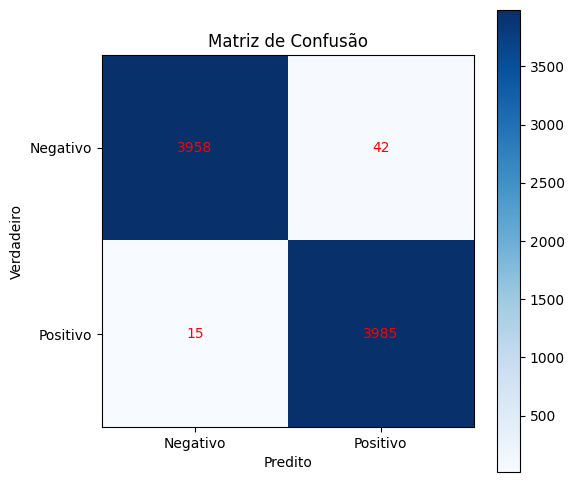

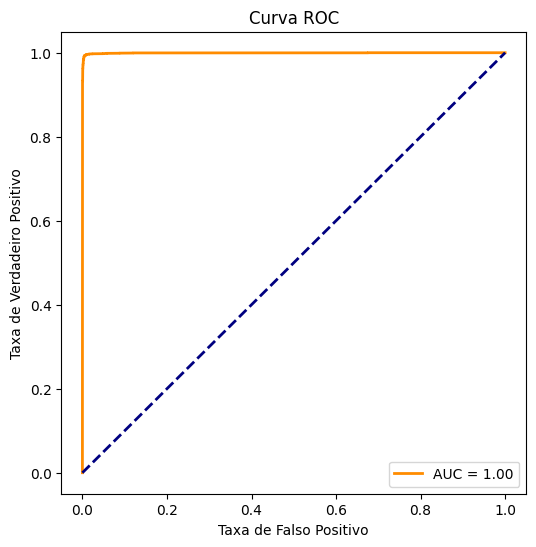

In [174]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title('Matriz de Confusão')
plt.colorbar()
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.xticks([0, 1], ['Negativo', 'Positivo'])
plt.yticks([0, 1], ['Negativo', 'Positivo'])

# Adicionar os números para cada célula
for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j],
                 ha="center", va="center", color="red")

plt.show()

# Calcular a curva ROC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend(loc="lower right")
plt.show()